In [1]:
from tadawol.strategies import recovery
from tadawol.strategies import record

In [2]:
strategy = recovery.Recovery()
data = strategy.simulate()

Historical data is extracted, rows_umber = 1050581
Simulating strategy for 2410 tickers
Simulation in progress : 8%
Simulation in progress : 17%
Simulation in progress : 25%
Simulation in progress : 33%
Simulation in progress : 41%
Simulation in progress : 50%
Simulation in progress : 58%
Simulation in progress : 66%
Simulation in progress : 75%
Simulation in progress : 83%
Simulation in progress : 91%
Simulation in progress : 100%


In [3]:
# JOIN RESULTS WITH TICKERS DATA
import pandas as pd
from math import log

from tadawol import yahoo
tickers_data = pd.read_csv(yahoo.TICKERS_LIST_PATH)

data = pd.merge(tickers_data, data, on="Ticker", how="inner")
data.rename(columns={"Volume_y": "Volume"}, inplace=True)


In [4]:
from math import log

def get_volume_category(volume):
    if log(volume) <= 14:
        return "Low Volume"
    if log(volume) <= 16:
        return "Medium Volume"
    return "High Volume"

data["Volume_category"] = data.Volume.map(get_volume_category)


In [5]:
import pandas as pd
import statistics 
import matplotlib.pyplot as plt

def _performance_by(df, column, index):
    
    x = []
    labels = []
    occurences = []
    win_percents = []
    i = 1
    for column_value, column_data in df.groupby([column]):
        labels.append(column_value)
        x.append(i)
        occurences.append(column_data.shape[0])
        win_percents.append(column_data["win_percent"].mean())
        i += 1
    
    f = plt.figure(index)
    plt.plot(x, occurences)
    plt.plot(x, len(x)* [statistics.mean(occurences)])
    plt.xticks(x, labels, rotation='vertical')
    f.show()
    
    index += 1
    g = plt.figure(index)
    plt.plot(x, win_percents)
    plt.xticks(x, labels, rotation='vertical')
    g.show()
    
    
def analyse_results(df: pd.DataFrame, print_figures: bool = True) -> None:
    df = df.copy(deep=True)
    print(f"Enter cases number = {df.shape[0]}")
    print("Average winning cases = {}".format(100 * df[df["win_percent"] >= 0].shape[0] / df.shape[0]))
    print("Average win = {}".format(round(df["win_percent"].mean(), 2)))
    if not print_figures:
        return
    
        
    df.loc[:, "month"] = df['Date'].map(lambda x: f"{x.month}/{x.year}")
    
    index = 1
    labels = ["month", "Country", "Sector", "week_previous_entries", "Volume_category"]
    for label in labels:
        _performance_by(df, label, index)
        index += 2

def print_bad_cases(df: pd.DataFrame, cases_number: int):

    df = df.sort_values(by=["win_percent"], ascending=True)
    print(df.head(cases_number)[["Ticker", "Date", "Close", "exit_price", "win_percent"]])
    

Enter cases number = 3899
Average winning cases = 60.194921774814055
Average win = 2.34


/Users/yassineameur/.virtualenvs/tadawol/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/yassineameur/.virtualenvs/tadawol/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


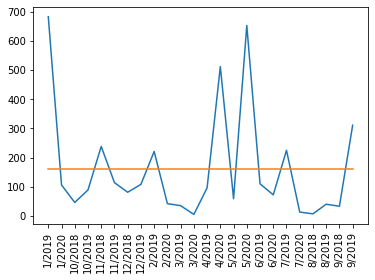

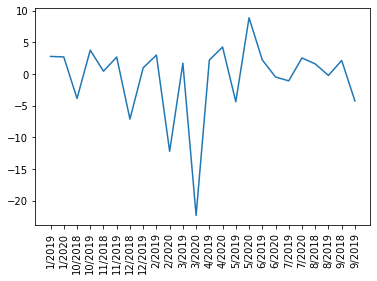

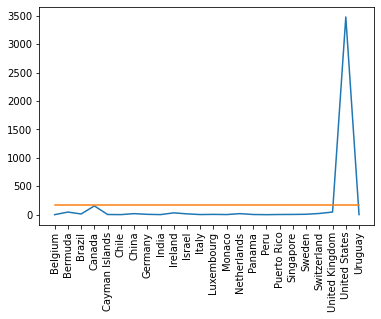

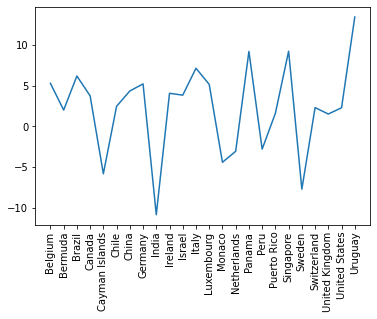

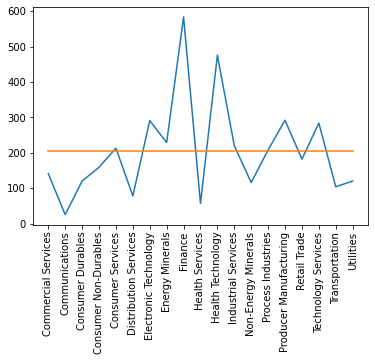

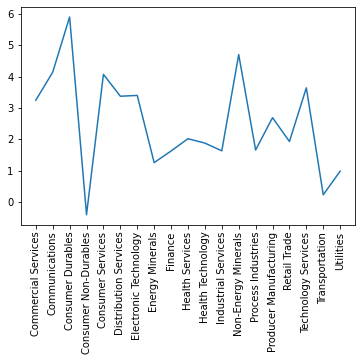

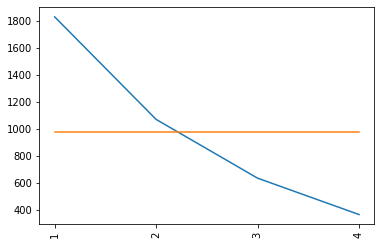

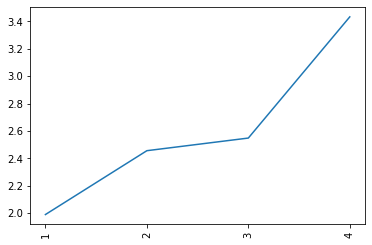

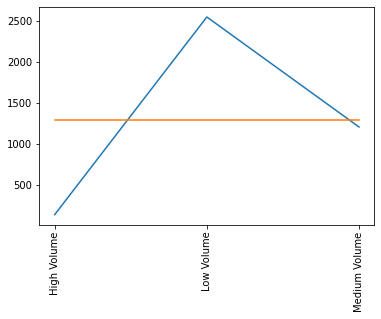

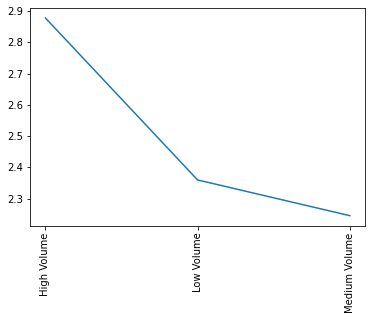

In [6]:
analyse_results(data)
#print_bad_cases(data, 5)

In [15]:
data_1 = data[data["week_previous_entries"] >= 2]
analyse_results(data_1, False)

Enter cases number = 2068
Average winning cases = 61.702127659574465
Average win = 2.66


In [18]:
print_bad_cases(data_1, 30)

     Ticker       Date       Close exit_price win_percent
271     KHC 2019-02-12   48.110001      34.95     -27.354
3875   ASIX 2020-02-14   19.410000       14.2    -26.8418
272     KHC 2019-02-13   47.639999      34.95    -26.6373
274     KHC 2019-02-15   47.619999      34.95    -26.6065
3873   ASIX 2020-02-12   19.290001       14.2    -26.3867
273     KHC 2019-02-14   47.340000      34.95    -26.1724
3876   ASIX 2020-02-18   19.209999       14.2    -26.0802
3874   ASIX 2020-02-13   18.840000       14.2    -24.6285
3086   RLGY 2019-08-28    6.130000       4.73    -22.8385
3208   GLNG 2020-03-06   10.560000       8.29    -21.4962
3554   STKL 2018-11-01    7.500000       5.93    -20.9333
3041   VRTU 2020-05-13   31.760000      25.19    -20.6864
3553   STKL 2018-10-31    7.420000       5.93    -20.0809
3878   ASIX 2020-02-21   17.730000       14.2    -19.9098
2381     PS 2018-12-13   24.340000      19.61     -19.433
2983    CLB 2019-07-26   53.029999      42.96    -18.9893
2982    CLB 20

In [9]:
recovery_strategy = recovery.Recovery()

In [10]:
df = recovery_strategy.get_today_entries()

Historical data is extracted, rows_umber = 1050581
Fetching data for 2763 tickers
Treated 0% of tickers
Treated 0% of tickers
Treated 0% of tickers
Treated 1% of tickers
Treated 1% of tickers
Treated 1% of tickers
Treated 1% of tickers
INFO:tadawol.yahoo:Treated 1% of tickers


KeyboardInterrupt: 

In [ ]:
data_sorted = data.sort_values(by="Date", ascending=False)
data_sorted.head(5)[["Ticker", "Date", "Close", "exit_price"]]

In [ ]:
print(list(data.columns))